### Decision Trees in SpockFlow: A Practical Guide

Welcome to the world of Decision Trees in SpockFlow! Decision Trees are powerful tools for automating decision-making processes based on defined conditions and actions. Let's dive into how you can leverage Decision Trees effectively within SpockFlow, including integration with Hamilton for creating executable pipelines.

#### Importing Necessary Packages

To begin, let's import the essential packages from SpockFlow:

In [1]:
from spockflow.components.tree import Tree, Action
from spockflow.core import initialize_spock_module
import pandas as pd

The `Tree` class allows us to construct decision trees, and `Action` serves as a wrapper for defining standardized outputs.

#### Defining Action Types

To maintain consistency in the outputs of our decision tree, we define an action type using `TypedDict` from the `typing_extensions` module:

In [2]:
from typing_extensions import TypedDict

class Reject(TypedDict):
    code: int
    description: str

RejectAction = Action[Reject]

Here, `RejectAction` specifies the structure of actions that our decision tree can produce.

#### Creating an Instance of the Tree

Next, let's create an instance of the `Tree`:

In [3]:
tree = Tree()

This `tree` object will be our canvas for defining conditions and their corresponding actions.

#### Adding Conditions to the Tree

Conditions in the decision tree are defined using decorators (`@tree.condition`). These conditions evaluate input data and trigger specified actions when conditions are met. Here’s an example of adding a condition:

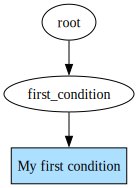

In [4]:
@tree.condition(output=RejectAction(code=102, description="My first condition"))
def first_condition(d: pd.Series, e: pd.Series, f: pd.Series) -> pd.Series:
    return (d > 5) & (e > 5) & (f > 5)
tree.visualize(get_value_name=lambda x: x["description"][0])

In this example, `first_condition` triggers a rejection with code `102` and description "My first condition" when certain criteria (`d > 5`, `e > 5`, `f > 5`) are fulfilled.

#### Nesting Conditions

You can nest conditions under parent conditions using decorators. Here’s how to nest conditions under `condition_a`:

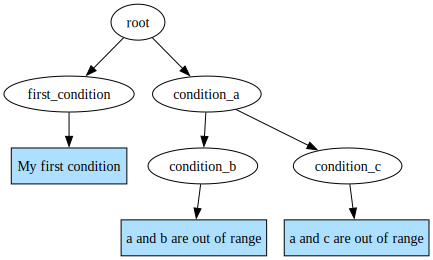

In [5]:
@tree.condition()
def condition_a(a: pd.Series) -> pd.Series:
    return a > 5

@condition_a.condition(output=RejectAction(code=100, description="a and b are out of range"))
def condition_b(b: pd.Series) -> pd.Series:
    return b > 5

@condition_a.condition(output=RejectAction(code=101, description="a and c are out of range"))
def condition_c(c: pd.Series) -> pd.Series:
    return c > 5
tree.visualize(get_value_name=lambda x: x["description"][0])

Note the usage of `@condition_a.condition` to define nested conditions (`condition_b` and `condition_c`) under `condition_a`.

#### Setting Default Actions

It’s essential to define a default action for cases where none of the conditions match. This is done using `set_default`:

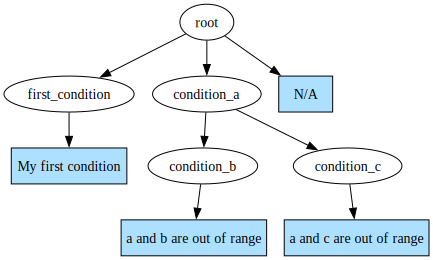

In [6]:
tree.set_default(output=RejectAction(code=-1, description="N/A"))

tree.visualize(get_value_name=lambda x: x["description"][0])

By default, all values are set to `pd.NA` when no specific conditions are met. The tree can now be executed with the following code:


In [7]:
test_data = pd.DataFrame({
    "a": [5,6,7,8,1,2,3,4],
    "b": [1,0,0,0,2,0,0,0],
    "c": [0,10,0,0,0,10,0,0],
    "d": [0,0,10,0,0,0,0,0],
    "e": [0,0,10,0,0,0,0,0],
    "f": [0,0,10,0,0,0,0,0],
    # Below used later in the tutorial
    "nums": [1,2,3,4,5,6,7,8],
    "input_condition": [True, True, False, False, False, False, True, True],
})
test_data

,a,b,c,d,e,f,nums,input_condition
0,5,1,0,0,0,0,1,True
1,6,0,10,0,0,0,2,True
2,7,0,0,10,10,10,3,False
3,8,0,0,0,0,0,4,False
4,1,2,0,0,0,0,5,False
5,2,0,10,0,0,0,6,False
6,3,0,0,0,0,0,7,True
7,4,0,0,0,0,0,8,True


In [8]:
tree.execute(inputs=test_data)

,code,description
0,-1,N/A
1,101,a and c are out of range
2,102,My first condition
3,-1,N/A
4,-1,N/A
5,-1,N/A
6,-1,N/A
7,-1,N/A



#### Specifying Conditions as Text

You can also specify conditions using text references. Here’s an example:

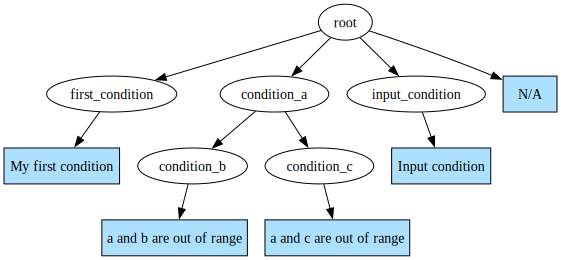

In [9]:
tree.condition(condition="input_condition", output=RejectAction(code=101, description="Input condition"))
tree.visualize(get_value_name=lambda x: x["description"][0])

In [10]:
tree.execute(inputs=test_data)

,code,description
0,101,Input condition
1,101,a and c are out of range
2,102,My first condition
3,-1,N/A
4,-1,N/A
5,-1,N/A
6,101,Input condition
7,101,Input condition


#### Including Subtrees

In SpockFlow, you can amplify the power of your Decision Trees by including subtrees. This feature allows you to nest complex decision logic within your main tree structure seamlessly. Here’s how you can include a subtree:

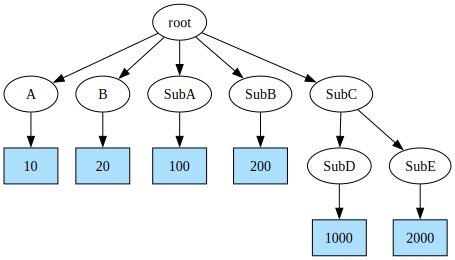

In [11]:
tree = Tree()
tree.condition(output=Action(value=10), condition='A')
tree.condition(output=Action(value=20), condition='B')

subtree = Tree()
subtree.condition(output=Action(value=100), condition='SubA')
subtree.condition(output=Action(value=200), condition='SubB')

cond_subtree = Tree()
cond_subtree.condition(output=Action(value=1000), condition='SubD')
cond_subtree.condition(output=Action(value=2000), condition='SubE')

tree.include_subtree(subtree)
tree.include_subtree(cond_subtree, condition="SubC")
tree.visualize(get_value_name=lambda x: str(x["value"][0]))

In this setup:
- The main `tree` defines conditions 'A' and 'B' with outputs 10 and 20 respectively.
- `subtree`, a separate instance of `Tree`, defines its own conditions 'SubA' and 'SubB' with outputs 100 and 200.
- `tree.include(subtree)` integrates `subtree` into `tree`, enabling `subtree`'s conditions to function as part of `tree`'s decision-making process.

This approach allows for hierarchical structuring of decision logic, making your Decision Trees in SpockFlow even more versatile and powerful.

#### Integration with Hamilton

SpockFlow seamlessly integrates with Hamilton to execute decision trees as part of data processing pipelines. Hamilton allows converting sequences of Python functions into executable Directed Acyclic Graphs (DAGs), enabling clear data flow management. Here's how you can incorporate our decision tree into a Hamilton pipeline:

In [12]:
%load_ext hamilton.plugins.jupyter_magic

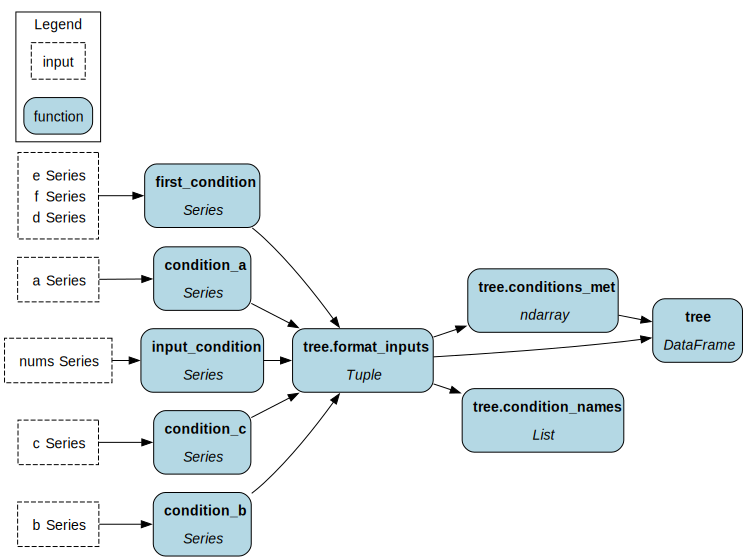

In [13]:
%%cell_to_module --display -m demo_tree

# Import necessary packages
from typing import TypedDict
import pandas as pd

from spockflow.components.tree import Tree, Action
from spockflow.core import initialize_spock_module

# Define Reject action type
class Reject(TypedDict):
    code: int
    description: str

RejectAction = Action[Reject]

def input_condition(nums: pd.Series) -> pd.Series:
    """input condition can be a value calculated just like any other value in a hamilton dag"""
    return nums % 2 == 0

# Initialize Tree
tree = Tree()

# Define conditions and actions
@tree.condition()
def condition_a(a: pd.Series) -> pd.Series:
    return a > 5

@condition_a.condition(output=RejectAction(code=100, description="a and b are out of range"))
def condition_b(b: pd.Series) -> pd.Series:
    return b > 5

@condition_a.condition(output=RejectAction(code=101, description="a and c are out of range"))
def condition_c(c: pd.Series) -> pd.Series:
    return c > 5

@tree.condition(output=RejectAction(code=102, description="My first condition"))
def first_condition(d: pd.Series, e: pd.Series, f: pd.Series) -> pd.Series:
    return (d > 5) & (e > 5) & (f > 5)

# Set condition with reference to external hamilton element
tree.condition(condition="input_condition", output=RejectAction(code=101, description="Input condition"))
# Set default action
tree.set_default(output=RejectAction(code=-1, description="N/A"))

# Initialize SpockFlow module for Hamilton
initialize_spock_module(__name__, output_names=["tree"])


In the above example:
- We define our decision tree and associated conditions.
- The initialize_spock_module function hooks into Hamilton's DAG creation system, enabling the construction of SpockFlow-specific nodes and specifying default outputs.

#### Executing the Hamilton DAG

Once defined, you can execute the Hamilton DAG using the SpockFlow Driver (Driver):

In [14]:
from spockflow.core import Driver

# Initialize Driver with the decision tree module
dr = Driver({}, demo_tree)

# Execute the DAG with test data
df = dr.execute(inputs=test_data)
print(df)

  code               description
0   -1                       N/A
1  101  a and c are out of range
2  102        My first condition
3  101           Input condition
4   -1                       N/A
5  101           Input condition
6   -1                       N/A
7  101           Input condition
